EEA - European Environment Agency
==

## Libraries

In [1]:
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import overpy
import geojsonio as gjs
import json
import ipyleaflet as ipy
import osmnx as ox
from shapely.geometry import Point, LineString, Polygon 
from descartes import PolygonPatch 
from IPython.display import IFrame 

In [3]:
ox.config(log_console=True, use_cache=True)

## Data preparation

### EEA Data

#### Idea

Combining all the EEA data to one large datasets.

In [22]:
'''
import os
import glob2
os.chdir("../EEA/data")

extension = 'csv'
all_filenames = [i for i in glob2.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])

#export to csv
combined_csv.to_csv( "EEA_total.csv", index=False, encoding='utf-8-sig')

os.chdir('/Users/davidecallegaro/Sync/300.000kms/Notebooks')

os.getcwd()
'''

### Meta Data

In [2]:
EEA_meta = pd.read_csv('../EEA/PanEuropean_metadata.csv',sep='\t')
EEA_meta = EEA_meta[(EEA_meta['Countrycode'] == 'ES')]
EEA_meta = EEA_meta.drop(['Countrycode','Namespace','Timezone','SamplingPoint','SamplingProces','Sample','MeasurementType',
               'AirQualityStationType','AirQualityStationNatCode','AirQualityStationEoICode','EquivalenceDemonstrated',
               'BuildingDistance','KerbDistance','MeasurementEquipment','AirQualityStationArea','InletHeight',
                          'Projection','ObservationDateEnd','AirPollutantCode','ObservationDateBegin','AirQualityNetwork'],
                         axis=1)
EEA_meta = EEA_meta.drop_duplicates()

In [15]:
EEA_meta.sort_values(by='Altitude', ascending = False).head()

,AirQualityStation,Longitude,Latitude,Altitude
24017,STA_ES1982A,0.729556,42.051341,1570.0
18353,STA_ES0009R,-3.142500,41.274170,1360.0
24626,STA_ES2083A,-6.192600,43.069600,1253.0
18228,STA_ES0007R,-3.534170,37.237220,1230.0
19995,STA_ES1310A,2.214273,42.312078,1226.0


In [16]:
count = pd.unique(EEA_meta['AirQualityStation'])
count.size

661

### no2 Data

In [3]:
EEA_tryout = pd.read_csv('../EEA/data/EEA_total.csv', sep=',')
EEA_tryout = EEA_tryout.drop(['Countrycode','Namespace','SamplingPoint','Sample','SamplingProcess',
                              'AirQualityStationEoICode','AirPollutant','AirPollutantCode',
                              'AveragingTime','UnitOfMeasurement','Validity','Verification','AirQualityNetwork'
                             ],
                         axis=1)

In [18]:
EEA_tryout.sort_values(by='DatetimeBegin').head()

,AirQualityStation,Concentration,DatetimeBegin,DatetimeEnd
1181345,STA_ES1672A,8.0,2017-01-01 00:00:00 +01:00,2017-01-01 01:00:00 +01:00
1181346,STA_ES1672A,9.0,2017-01-01 01:00:00 +01:00,2017-01-01 02:00:00 +01:00
1181347,STA_ES1672A,11.0,2017-01-01 02:00:00 +01:00,2017-01-01 03:00:00 +01:00
1181348,STA_ES1672A,8.0,2017-01-01 03:00:00 +01:00,2017-01-01 04:00:00 +01:00
1181349,STA_ES1672A,9.0,2017-01-01 04:00:00 +01:00,2017-01-01 05:00:00 +01:00


## Merging all Datasets

In [4]:
EEA_final = EEA_meta.merge(EEA_tryout, on=['AirQualityStation'])    

In [20]:
EEA_final.sort_values(by='DatetimeBegin').head()

,AirQualityStation,Longitude,Latitude,Altitude,Concentration,DatetimeBegin,DatetimeEnd
2949307,STA_ES1672A,-2.619444,42.518333,480.0,8.0,2017-01-01 00:00:00 +01:00,2017-01-01 01:00:00 +01:00
2949308,STA_ES1672A,-2.619444,42.518333,480.0,9.0,2017-01-01 01:00:00 +01:00,2017-01-01 02:00:00 +01:00
2949309,STA_ES1672A,-2.619444,42.518333,480.0,11.0,2017-01-01 02:00:00 +01:00,2017-01-01 03:00:00 +01:00
2949310,STA_ES1672A,-2.619444,42.518333,480.0,8.0,2017-01-01 03:00:00 +01:00,2017-01-01 04:00:00 +01:00
2949311,STA_ES1672A,-2.619444,42.518333,480.0,9.0,2017-01-01 04:00:00 +01:00,2017-01-01 05:00:00 +01:00


In [5]:
gdf_EEA = gpd.GeoDataFrame(EEA_final, geometry=gpd.points_from_xy(EEA_final.Longitude, EEA_final.Latitude))
gdf_EEA = gdf_EEA.drop(['Longitude','Latitude'],axis=1)

In [22]:
gdf_EEA.head()

,AirQualityStation,Altitude,Concentration,DatetimeBegin,DatetimeEnd,geometry
0,STA_ES0001R,917.0,2.66,2019-01-25 01:00:00 +01:00,2019-01-25 02:00:00 +01:00,POINT (-4.35056 39.54694)
1,STA_ES0001R,917.0,1.91,2019-01-25 02:00:00 +01:00,2019-01-25 03:00:00 +01:00,POINT (-4.35056 39.54694)
2,STA_ES0001R,917.0,1.43,2019-01-25 03:00:00 +01:00,2019-01-25 04:00:00 +01:00,POINT (-4.35056 39.54694)
3,STA_ES0001R,917.0,1.12,2019-01-25 04:00:00 +01:00,2019-01-25 05:00:00 +01:00,POINT (-4.35056 39.54694)
4,STA_ES0001R,917.0,1.18,2019-01-25 05:00:00 +01:00,2019-01-25 06:00:00 +01:00,POINT (-4.35056 39.54694)


## Plot

#### Idea

Import the map of spain from GeoPandas and plot the station points combining with the map.

In [6]:
import geoplot
import mapclassify

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
spain = world[world['name'] == ('Spain')]
spain.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
132,48958159,Europe,Spain,ESP,1690000.0,"POLYGON ((-7.45373 37.09779, -7.53711 37.42890..."


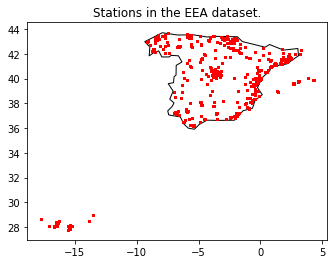

In [8]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
spain.plot(ax=ax, color='white', edgecolor='black')
gdf_EEA.plot(ax=ax, marker='o', color='red', markersize=1)
plt.title("Stations in the EEA dataset.")

plt.show();

In [40]:
'''
# export dataset to geojson
gdf_EEA.to_file("../Datasets/gdf_EEA.geojson", driver='GeoJSON')
'''

## Extra Data 

We had access to this dataset only subsequently, therefore we processed it in a second moment.

### Grid Spain 

In [5]:
grid = gpd.read_file("../EEA/2017Shapefile/Interpolation data 1 km grid/EEA_1kmgrid_2017.shp")
pd.set_option('display.max_columns', None)

In [6]:
grid["COUNTRY"].unique()

array(['PT', 'ES', 'IS', 'UK', 'IE', 'FR', 'IM', 'JG', 'DK', 'AD', 'NO',
       'BE', 'NL', 'CH', 'LU', 'DE', 'IT', 'MC', 'LI', 'AT', 'SE', 'CZ',
       'SM', 'SI', 'HR', 'PL', 'MT', 'FI', 'BA', 'HU', 'SK', 'LV', 'RS',
       'LT', 'EE', 'ME', 'AL', 'RO', 'GR', 'KS', 'MK', 'BG', 'CY', 'TR'],
      dtype=object)

In [7]:
list(grid.columns)

['OBJECTID',
 'CellCode',
 'EofOrigin',
 'NofOrigin',
 'POINT_X',
 'POINT_Y',
 'LAT',
 'LON',
 'CODE',
 'COUNTRY',
 'POPULATION',
 'PM10_avg',
 'PM10_p904',
 'PM25_avg',
 'O3_p932',
 'O3_SOMO35',
 'NO2_avg',
 'dif_PM_avg',
 'dif_PMp904',
 'dif_PM25',
 'dif_O3p932',
 'dif_O3_S35',
 'dif_NO2avg',
 'weight_urb',
 'weight_tr',
 'NO2_avg_b',
 'NO2_avg_ut',
 'PM10_avg_b',
 'PM10avg_ut',
 'PM25_avg_b',
 'PM25avg_ut',
 'O3_S10',
 'dif_O3_S10',
 'geometry']

In [8]:
spain_grid = grid[grid['COUNTRY'] == 'ES']

In [9]:
spain_grid = spain_grid.drop(['COUNTRY','OBJECTID','CellCode', 'PM10_avg', 'PM10_p904', 'PM25_avg', 'dif_PM_avg', 'dif_PMp904', 
                              'dif_PM25', 'PM10_avg_b', 'PM10avg_ut', 'PM25_avg_b', 'PM25avg_ut', 'POINT_X', 'POINT_Y','NO2_avg_b',
                             'dif_O3p932', 'dif_NO2avg','dif_O3_S35', 'dif_O3_S10', 'POPULATION','EofOrigin', 'NofOrigin', 'CODE'], axis=1)

#### Meaning columns

EofOriginn/a (grid cell coordinate X-direction, right bottom corner of the cell)

NofOriginn/a (grid cell coordinate Y-direction, right bottom corner of the cell)

POINT_Xn/a (grid cell coordinate X-direction, centre of the cell) 

POINT_Yn/a (grid cell coordinate Y-direction, centre of the cell) 

LAT= latitude cell centre (DD = Decimal Degrees)

LON= longitude cell centre (DD = Decimal Degrees)

COUNTRYn/a

POPULATION n/a (population in the grid cell)

PM10_avg= PM10 annual average values

PM10_p904= PM10 90.4 percentile of daily average

PM25_avg= PM2.5 annual average values

O3_p932= Ozone 93.2 percentile of daily maximum 8-hour running means

O3_SOMO35= Ozone SOMO35 values

NO2_avg= NO2 annual average values

dif_PM_avg= Interannual difference in PM10 annual average values 2017-2016 

dif_PMp904= Interannual difference in PM10 90.4 percentile of daily average 2017-2016 

dif_PM25= Interannual difference in PM2.5 annual average values 2017-2016 

dif_O3p932= Interannual difference in Ozone 93.2 percentile of daily maximum 8-hour running means 2017-2016 

dif_O3_S35= Interannual difference in Ozone SOMO35 values 2017-2016 

dif_NO2avg= Interannual difference in NO2 annual average values 2017-2016 

weight_urbn/a (weight representing the ratio of the urban character of the cell)

weight_trn/a (weight representing the ratio of areas exposed to traffic air quality in the cell)

NO2_avg_bn/a (background grid layer of NO2 annual average for 2017)

NO2_avg_utn/a urban traffic grid layer of NO2 annual average for 2017)

PM10_avg_bn/a (background grid layer of PM10 annual average for 2017)

PM10_avg_utn/a urban traffic grid layer of PM10 annual average for 2017)

PM25_avg_bn/a (background grid layer of PM2.5 annual average for 2017)

PM25_avg_utn/a urban traffic grid layer of OM2.5 annual average for 2017)

O3_SOMO10= Ozone SOMO10 values

dif_O3_S10= Interannual differences in Ozone SOMO10 values

In [10]:
spain_grid.head()

,LAT,LON,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10,geometry
33280,-9.28496,42.8856,111.845,5387.27,2.744,0.0,0.0,11.975,22174.500000,"POLYGON ((2760000.000 2399000.000, 2760000.000..."
33281,-9.29662,42.9204,105.190,4304.51,2.655,0.0,0.0,12.170,21000.599609,"POLYGON ((2760000.000 2403000.000, 2760000.000..."
33718,-9.27014,42.8792,111.845,5387.27,2.775,0.0,0.0,11.954,22174.500000,"POLYGON ((2761000.000 2398000.000, 2761000.000..."
33719,-9.27305,42.8879,111.845,5387.27,0.942,0.0,0.0,11.968,22174.500000,"POLYGON ((2761000.000 2399000.000, 2761000.000..."
33720,-9.27596,42.8966,105.190,4304.51,0.541,0.0,0.0,11.999,21000.599609,"POLYGON ((2761000.000 2400000.000, 2761000.000..."


#### Creating the coordinate (LAT, LON) and dropping the old columns

In [11]:
spain_grid_up = gpd.GeoDataFrame(spain_grid, geometry=gpd.points_from_xy(spain_grid.LON, spain_grid.LAT))
spain_grid_up = spain_grid_up.drop(['LAT','LON'],axis=1)

In [12]:
spain_grid_up.head()

,O3_p932,O3_SOMO35,NO2_avg,weight_urb,weight_tr,NO2_avg_ut,O3_S10,geometry
33280,111.845,5387.27,2.744,0.0,0.0,11.975,22174.500000,POINT (42.88560 -9.28496)
33281,105.190,4304.51,2.655,0.0,0.0,12.170,21000.599609,POINT (42.92040 -9.29662)
33718,111.845,5387.27,2.775,0.0,0.0,11.954,22174.500000,POINT (42.87920 -9.27014)
33719,111.845,5387.27,0.942,0.0,0.0,11.968,22174.500000,POINT (42.88790 -9.27305)
33720,105.190,4304.51,0.541,0.0,0.0,11.999,21000.599609,POINT (42.89660 -9.27596)


#### Exporting Dataset

In [15]:
spain_grid_up.to_file("../Datasets/spain_grid.geojson", driver='GeoJSON')